Import everything that is needed.

For high-quality work, it is recommended to do "Factory reset runtime" every time before uploading new images.

In [ ]:
from torchvision.transforms.functional import to_pil_image
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn.functional as F
import matplotlib.pylab as plt
from google.colab import files
from torch import optim
from PIL import Image
from time import time
import torch
import json
import os

Upload pictures.

In [ ]:
print('Upload an image to transfer styles to(content image)...')
content_img = Image.open(list(files.upload().keys())[0])
print()
print('Upload an image with the first style(style image)...')
style1_img = Image.open(list(files.upload().keys())[0])
print()
print('Upload an image with the second style(style image)...')
style2_img = Image.open(list(files.upload().keys())[0])

Загрузите изображение, на которое переносить стили(content image)...


Saving content.jpg to content.jpg

Загрузите изображение с первым стилем(style image)...


Saving style1.jpg to style1.jpg

Загрузите изображение со вторым стилем(style image)...


Saving style1221.jpg to style1221.jpg


Write all the necessary functions for operation.

[Reference article](http://cs231n.stanford.edu/reports/2017/pdfs/401.pdf)

In [ ]:
def imgtensor2pil(img_tensor): 
  # This function turns tensors into a PIL image
  img_tensor_c = img_tensor.clone().detach()
  img_tensor_c *= torch.tensor(std_rgb).view(3,1,1)
  img_tensor_c += torch.tensor(mean_rgb).view(3,1,1)
  img_tensor_c = img_tensor_c.clamp(0,1)
  img_pil = to_pil_image(img_tensor_c)
  return img_pil

def get_features(x, model, layers): 
  # A function that obtains the features of the intermediate layers
  features = {}
  for name, layer in enumerate(model.children()):
    x = layer(x)
    if str(name) in layers:
      features[layers[str(name)]] = x
  return features

def gram_matrix(x): 
  # Function that counts the Gram matrix
  n, c, h, w = x.size()
  x = x.view(n*c, h*w)
  gram = torch.mm(x, x.t())
  return gram

def get_content_loss(pred_features, target_features, layer): 
  # Function calculating the content loss
  target = target_features[layer]
  pred = pred_features[layer]
  loss = F.mse_loss(pred, target)
  return loss

def get_style_loss(pred_features, target_features, style_layers_dict): 
  # Function calculating the style loss
  loss = 0
  for layer in style_layers_dict:
    pred_fea = pred_features[layer]
    pred_gram = gram_matrix(pred_fea)
    n, c, h, w = pred_fea.shape
    target_gram = gram_matrix(target_features[layer])
    layer_loss = style_layers_dict[layer] * F.mse_loss(pred_gram, target_gram)
    loss += layer_loss/ (n * c * h * w)
  return loss

h, w = 256, 384 # Change size of picture
mean_rgb = (0.485, 0.456, 0.406) # Normalization
std_rgb = (0.229, 0.224, 0.225)  # parametrs
transformer = transforms.Compose([transforms.Resize((h,w)), # Consider transformations 
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean_rgb, std_rgb)])

Let's process the received images.

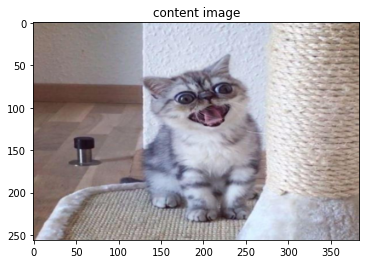

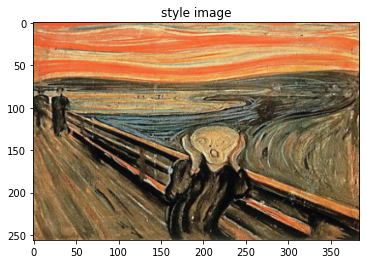

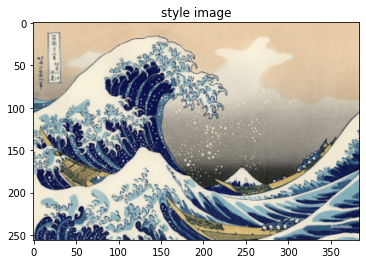

In [ ]:
# Apply transformations
content_tensor = transformer(content_img)
style1_tensor = transformer(style1_img)
style2_tensor = transformer(style2_img)

# Show images
plt.imshow(imgtensor2pil(content_tensor))
plt.title('content image')
plt.show()

plt.imshow(imgtensor2pil(style1_tensor))
plt.title('style image')
plt.show()

plt.imshow(imgtensor2pil(style2_tensor))
plt.title('style image')
plt.show()

Load the pre-trained model and freeze the model parameters.



In [ ]:
# Upload model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_vgg = models.vgg19(pretrained=True).features.to(device).eval()

# Freeze parametrs
for param in model_vgg.parameters():
  param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


Now let's choose hyperparameters for training.

In [ ]:
# Choose the layers to get features from
feature_layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',
                  '28': 'conv5_1'}
    
con_tensor = content_tensor.unsqueeze(0).to(device)
sty1_tensor = style1_tensor.unsqueeze(0).to(device)
sty2_tensor = style2_tensor.unsqueeze(0).to(device)

content_features = get_features(con_tensor, model_vgg, feature_layers)
style1_features = get_features(sty1_tensor, model_vgg, feature_layers)
style2_features = get_features(sty2_tensor, model_vgg, feature_layers)

# Transfer the content and apply styles and update the tensor
input_tensor = con_tensor.clone().requires_grad_(True)
optimizer = optim.Adam([input_tensor], lr=0.01)

num_epochs = 1000
content_weight = 1e1 # Final loss is weighted sum
style_weight = 1e4   # so consider weights for content and style losses
content_layer = 'conv5_1' # Content loss layer
style_layers_dict = {'conv1_1': 0.75, # Weigths of style loss
                     'conv2_1': 0.5,  # on different layers
                     'conv3_1': 0.25,
                     'conv4_1': 0.25,
                     'conv5_1': 0.25}

Let's start training... 

And get the picture.

epoch 0, content loss: 0.0, style loss 2.8e+02
epoch 100, content loss: 3.1, style loss 6.5e+01
epoch 200, content loss: 3.3, style loss 5.9e+01
epoch 300, content loss: 3.5, style loss 5.7e+01
epoch 400, content loss: 3.6, style loss 5.6e+01
epoch 500, content loss: 3.6, style loss 5.5e+01
epoch 600, content loss: 3.7, style loss 5.4e+01
epoch 700, content loss: 3.7, style loss 5.4e+01
epoch 800, content loss: 3.8, style loss 5.4e+01
epoch 900, content loss: 3.8, style loss 5.4e+01
epoch 1000, content loss: 3.8, style loss 5.3e+01

Время прошло 0.41 мин



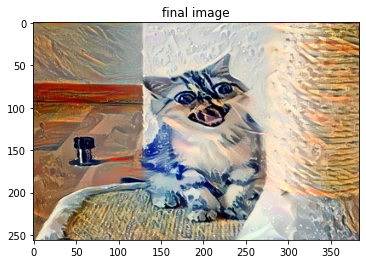

In [ ]:
tic = time()
for epoch in range(num_epochs+1):
  optimizer.zero_grad()
  input_features = get_features(input_tensor, model_vgg, feature_layers)
  content_loss = get_content_loss(input_features, content_features, content_layer) # content loss
  style1_loss = get_style_loss(input_features, style1_features, style_layers_dict) # style loss of first picture
  style2_loss = get_style_loss(input_features, style2_features, style_layers_dict) # style loss of second picture
  style_loss = style1_loss + style2_loss # sum of losses
  style_loss = (style1_loss**2 + style2_loss**2) / style_loss # weighted style  loss
  total_loss = content_weight * content_loss + style_weight * style_loss # weighted total loss
  total_loss.backward(retain_graph=True)
  optimizer.step()
  if epoch % 100 == 0:
    print('epoch {}, content loss: {:.2}, style loss {:.2}'.format(epoch, content_loss, style_loss))
print()
print('Время прошло {:.2} мин'.format( (time() - tic) / 60) )
print()
plt.title('final image')
plt.imshow(imgtensor2pil(input_tensor[0].cpu()));